In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('DM_ethereum').getOrCreate()

ep = spark.read.csv('Dataset_main/ethereum_classic_price 1.csv',header=True,inferSchema=True)

In [2]:
import pandas as pd
new_ep = ep.select('Open', 'High', 'Low', 'Close')
new_ep.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Open,1761,7.4583363719477545,8.426770726753162,0.604737,44.53
High,1761,7.867908806360018,9.09130871892865,0.766068,53.15
Low,1761,7.044287735945492,7.740564729267633,0.452446,40.85
Close,1761,7.477006630891537,8.452638640291166,0.602402,44.73


In [3]:
#Reduce data.
from pyspark.ml.feature import VectorAssembler

vector_assembler = VectorAssembler(inputCols = ['Open', 'High', 'Low', 'Close'], outputCol = 'features')
vector_output = vector_assembler.transform(new_ep)
vector_output.printSchema()
vector_output.head(1)

root
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- features: vector (nullable = true)



[Row(Open=39.41, High=43.96, Low=38.23, Close=38.47, features=DenseVector([39.41, 43.96, 38.23, 38.47]))]

In [4]:
vector_output = vector_output.select(['features', 'High'])

print(vector_output.head(1))
pd.DataFrame(vector_output.take(10), columns=vector_output.columns)

[Row(features=DenseVector([39.41, 43.96, 38.23, 38.47]), High=43.96)]


,features,High
0,"[39.41, 43.96, 38.23, 38.47]",43.96
1,"[34.69, 40.26, 33.93, 39.29]",40.26
2,"[35.01, 35.08, 31.52, 34.88]",35.08
3,"[34.97, 35.4, 34.38, 34.99]",35.40
4,"[34.43, 35.34, 32.9, 35.03]",35.34
5,"[34.83, 35.65, 32.83, 34.53]",35.65
6,"[34.32, 36.44, 33.4, 35.04]",36.44
7,"[29.88, 34.73, 28.32, 33.96]",34.73
8,"[24.31, 30.33, 24.31, 29.88]",30.33
9,"[24.53, 26.0, 21.42, 24.13]",26.00


In [5]:
#Split data.
train_data,test_data = vector_output.randomSplit([0.8,0.2])

#Describe train data.
train_ep = train_data.describe()
pd.DataFrame(train_ep.take(5), columns=train_ep.columns)

,summary,High
0,count,1392
1,mean,7.995037803879314
2,stddev,9.219705267743802
3,min,0.766068
4,max,53.15


In [6]:
#Describe test data.
test_ep = test_data.describe()
pd.DataFrame(test_ep.take(5), columns=test_ep.columns)

,summary,High
0,count,369
1,mean,7.388332750677507
2,stddev,8.584750844161974
3,min,0.782389
4,max,46.5


In [7]:
#Linear Regression.
from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol='features', labelCol='High')
lr_model = lr.fit(train_data)
print("Coefficients: ") 
x = 0
for coe in str(lr_model.coefficients)[1:].replace("]","").split(','):
    print("\t(High/"+new_ep.columns[x]+"): "+coe)
    x += 1

print("Intercept: " + str(lr_model.intercept) + "\n")

data_summary = lr_model.summary
print("RMSE: " + str(data_summary.rootMeanSquaredError))
print("R2: " + str(data_summary.r2))
print("\n")

data_resi = data_summary.residuals
pd.DataFrame(data_resi.take(10), columns=data_resi.columns)

Coefficients: 
	(High/Open): 3.591332403548809e-16
	(High/High): 0.9999999999999996
	(High/Low): -3.2883509954096917e-16
	(High/Close): 5.494666525996323e-16
Intercept: -2.4061979388221818e-17

RMSE: 2.3156168023303406e-15
R2: 1.0




,residuals
0,-1.110223e-16
1,-1.110223e-16
2,-1.110223e-16
3,-1.110223e-16
4,-1.110223e-16
5,-1.110223e-16
6,-1.110223e-16
7,-2.220446e-16
8,-2.220446e-16
9,-2.220446e-16


In [8]:
#Plotting for residuals.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

resi = data_resi.toPandas()

plt.hist(resi['residuals'], 50)
plt.xlabel('residuals')
plt.title('residuals Histogram')

plt.show()

<Figure size 640x480 with 1 Axes>

In [9]:
from pyspark.ml.feature import VectorAssembler
vector_assembler = VectorAssembler(inputCols = [ 'Open', 'High', 'Low', 'Close'], outputCol = 'features')
vector_output = vector_assembler.transform(new_ep)
vector_output.printSchema()
vector_output.head(1)

root
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- features: vector (nullable = true)



[Row(Open=39.41, High=43.96, Low=38.23, Close=38.47, features=DenseVector([39.41, 43.96, 38.23, 38.47]))]

In [10]:
vector_output = vector_output.select(['features', 'High'])
print(vector_output.head(1))
vector_output.show(3)

[Row(features=DenseVector([39.41, 43.96, 38.23, 38.47]), High=43.96)]
+--------------------+-----+
|            features| High|
+--------------------+-----+
|[39.41,43.96,38.2...|43.96|
|[34.69,40.26,33.9...|40.26|
|[35.01,35.08,31.5...|35.08|
+--------------------+-----+
only showing top 3 rows



In [11]:
train_data,test_data = vector_output.randomSplit([0.8,0.2])
train_data.describe().show()
test_data.describe().show()

+-------+-----------------+
|summary|             High|
+-------+-----------------+
|  count|             1407|
|   mean|7.813553125799576|
| stddev| 9.07154519924294|
|    min|         0.766068|
|    max|            53.15|
+-------+-----------------+

+-------+-----------------+
|summary|             High|
+-------+-----------------+
|  count|              354|
|   mean|8.083949604519772|
| stddev|9.179172062716058|
|    min|         0.861533|
|    max|            47.94|
+-------+-----------------+



In [12]:
from pyspark.ml.regression import LinearRegression
# Instantiate the instance.
lr = LinearRegression(featuresCol='features', labelCol='High')

# Fit the training data.
lr_model = lr.fit(train_data)

# Print the coefficients.
print("Coefficients: " + str(lr_model.coefficients))

# Print the intercept.
print("Intercept: " + str(lr_model.intercept) + "\n")

# Summarise the model and print out some evaluation metrics.
training_summary = lr_model.summary

# Print RMSE. 
print("RMSE: " + str(training_summary.rootMeanSquaredError))

# Print R2.
print("R2: " + str(training_summary.r2))

Coefficients: [0.0,1.0,0.0,0.0]
Intercept: 0.0

RMSE: 0.0
R2: 1.0


In [13]:
# Linear Regression on train data
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='High', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_data)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.25416220801710965,0.4319214045291355,0.061851881044872284,0.2696825520651561]
Intercept: 0.12140658482800051


In [14]:
lr_predictions = lr_model.transform(test_data) ---I1
lr_predictions.select("prediction","High","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator

lrR2_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="High",metricName="r2")
print("R Squared (R2) = %g" % lrR2_evaluator.evaluate(lr_predictions))

lrMAE_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="High",metricName="mae")
print("Mean Absolute Error (MAE) = %g" % lrMAE_evaluator.evaluate(lr_predictions))

lrRMSE_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="High",metricName="rmse")
print("Root Mean Squared Error (RMSE) = %g" % lrRMSE_evaluator.evaluate(lr_predictions))

+------------------+--------+--------------------+
|        prediction|    High|            features|
+------------------+--------+--------------------+
|0.9649577888567106|0.861533|[0.771917,0.86153...|
|1.0041647877040114|0.878762|[0.86104,0.878762...|
| 1.040660762066315|0.921573|[0.887828,0.92157...|
|1.0374959178989445|0.909434|[0.900257,0.90943...|
|1.1055904214332468|0.998996|[0.909894,0.99899...|
+------------------+--------+--------------------+
only showing top 5 rows

R Squared (R2) = 0.997642
Mean Absolute Error (MAE) = 0.22842
Root Mean Squared Error (RMSE) = 0.445119


In [36]:
# Linear Regression on train data---I3
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='High', maxIter=15, regParam=0.5, elasticNetParam=0.8)
lr_model = lr.fit(train_data)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.23616147166239415,0.4667941155861875,0.01731446817519504,0.27244391376031335]
Intercept: 0.2733265934477807


In [37]:
lr_predictions = lr_model.transform(test_data)
lr_predictions.select("prediction","High","features").show(5)

from pyspark.ml.evaluation import RegressionEvaluator

lrR2_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="High",metricName="r2")
print("R Squared (R2) = %g" % lrR2_evaluator.evaluate(lr_predictions))

lrMAE_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="High",metricName="mae")
print("Mean Absolute Error (MAE) = %g" % lrMAE_evaluator.evaluate(lr_predictions))

lrRMSE_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="High",metricName="rmse")
print("Root Mean Squared Error (RMSE) = %g" % lrRMSE_evaluator.evaluate(lr_predictions))

+------------------+--------+--------------------+
|        prediction|    High|            features|
+------------------+--------+--------------------+
|1.1013471443194616|0.861533|[0.771917,0.86153...|
|1.1355621504014488|0.878762|[0.86104,0.878762...|
|1.1719044464591775|0.921573|[0.887828,0.92157...|
|  1.16789407198149|0.909434|[0.900257,0.90943...|
|1.2381793507697285|0.998996|[0.909894,0.99899...|
+------------------+--------+--------------------+
only showing top 5 rows

R Squared (R2) = 0.996742
Mean Absolute Error (MAE) = 0.299153
Root Mean Squared Error (RMSE) = 0.523198


In [15]:
# Using our Linear Regression model to make some predictions.

predictions = lr_model.transform(test_data)
predictions.select("prediction","High","features").show()

+------------------+--------+--------------------+
|        prediction|    High|            features|
+------------------+--------+--------------------+
|0.9649577888567106|0.861533|[0.771917,0.86153...|
|1.0041647877040114|0.878762|[0.86104,0.878762...|
| 1.040660762066315|0.921573|[0.887828,0.92157...|
|1.0374959178989445|0.909434|[0.900257,0.90943...|
|1.1055904214332468|0.998996|[0.909894,0.99899...|
|1.0705248781367847|0.956011|[0.913579,0.95601...|
|1.0628422339999462|0.942472|[0.917254,0.94247...|
| 1.072516933541801|0.958333|[0.93027,0.958333...|
|1.0695934263578994|0.941046|[0.941046,0.94104...|
|1.1188849600472228|     1.0|[0.995573,1.0,0.9...|
|1.1699385227577046|    1.04|[1.03,1.04,1.01,1...|
|1.1725977389485749|    1.05|[1.04,1.05,0.9856...|
|1.2087876881526094|    1.08|[1.07,1.08,1.02,1...|
|1.2482627695423683|    1.13|[1.12,1.13,1.06,1...|
| 1.340168492668272|    1.23|[1.16,1.23,1.16,1...|
|1.3270556470919175|     1.2|[1.17,1.2,1.16,1.18]|
|1.3231997484165945|    1.19|[1

In [16]:
# Importing the LR package. ---I2
from pyspark.ml.regression import LinearRegression

# Instantiate the instance.
lr = LinearRegression(featuresCol='features', labelCol='High')

# Fit the vector_output
lr_model = lr.fit(vector_output)

# Print the coefficients.
print("Coefficients: " + str(lr_model.coefficients))

# Print the intercept.
print("Intercept: " + str(lr_model.intercept) + "\n")

# Summarise the model and print out some evaluation metrics.
vdf3_Summary = lr_model.summary

# Print MAE (Mean Absolute Error)
print("MAE: " + str(vdf3_Summary.meanAbsoluteError))

# Print RMSE (Root Mean Squared Error) 
print("RMSE: " + str(vdf3_Summary.rootMeanSquaredError))

# Print R2 (R Squarred)
print("R2: " + str(vdf3_Summary.r2))

Coefficients: [3.5872505322974137e-16,0.9999999999999994,-3.164968304102339e-16,5.446632011051353e-16]
Intercept: -5.1729286299937506e-17

MAE: 4.814118691673876e-16
RMSE: 1.276322627370726e-15
R2: 1.0


In [17]:
vector_output.describe().show()


+-------+-----------------+
|summary|             High|
+-------+-----------------+
|  count|             1761|
|   mean|7.867908806360018|
| stddev| 9.09130871892865|
|    min|         0.766068|
|    max|            53.15|
+-------+-----------------+



In [18]:
# Linear Regression model 

lr_predictions = lr_model.transform(vector_output)
lr_predictions.select("prediction","High","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator

lrR2_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="High",metricName="r2")
print("R Squared (R2) = %g" % lrR2_evaluator.evaluate(lr_predictions))

lrMAE_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="High",metricName="mae")
print("Mean Absolute Error (MAE) = %g" % lrMAE_evaluator.evaluate(lr_predictions))

lrRMSE_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="High",metricName="rmse")
print("Root Mean Squared Error (RMSE) = %g" % lrRMSE_evaluator.evaluate(lr_predictions))

+------------------+-----+--------------------+
|        prediction| High|            features|
+------------------+-----+--------------------+
|             43.96|43.96|[39.41,43.96,38.2...|
|             40.26|40.26|[34.69,40.26,33.9...|
|35.080000000000005|35.08|[35.01,35.08,31.5...|
|              35.4| 35.4|[34.97,35.4,34.38...|
| 35.34000000000001|35.34|[34.43,35.34,32.9...|
+------------------+-----+--------------------+
only showing top 5 rows

R Squared (R2) = 1
Mean Absolute Error (MAE) = 4.81412e-16
Root Mean Squared Error (RMSE) = 1.27632e-15


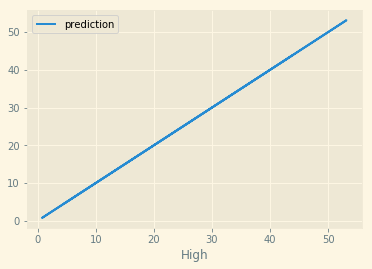

In [19]:
# Convert the Pyspark contructed dataframe to Pandas dataframe to visualize
lr_predictionsPandas = lr_predictions.toPandas()

plt.style.use('Solarize_Light2')
lr_predictionsPandas.plot(x="High" ,y='prediction')

In [20]:
lr_predictions.describe().show()

+-------+-----------------+-----------------+
|summary|             High|       prediction|
+-------+-----------------+-----------------+
|  count|             1761|             1761|
|   mean|7.867908806360018|7.867908806360018|
| stddev| 9.09130871892865|9.091308718928648|
|    min|         0.766068|         0.766068|
|    max|            53.15|53.14999999999999|
+-------+-----------------+-----------------+



In [21]:
lr_predictions.show()


+--------------------+-----+------------------+
|            features| High|        prediction|
+--------------------+-----+------------------+
|[39.41,43.96,38.2...|43.96|             43.96|
|[34.69,40.26,33.9...|40.26|             40.26|
|[35.01,35.08,31.5...|35.08|35.080000000000005|
|[34.97,35.4,34.38...| 35.4|              35.4|
|[34.43,35.34,32.9...|35.34| 35.34000000000001|
|[34.83,35.65,32.8...|35.65|35.650000000000006|
|[34.32,36.44,33.4...|36.44|36.440000000000005|
|[29.88,34.73,28.3...|34.73|34.730000000000004|
|[24.31,30.33,24.3...|30.33|             30.33|
|[24.53,26.0,21.42...| 26.0|              26.0|
|[25.95,26.65,23.0...|26.65|26.650000000000002|
|[21.89,26.21,21.0...|26.21|             26.21|
|[18.15,21.96,18.1...|21.96|             21.96|
|[19.18,20.45,17.4...|20.45|             20.45|
|[16.75,19.42,14.0...|19.42|19.420000000000005|
|[20.76,21.19,15.8...|21.19|21.190000000000005|
|[24.19,24.73,19.9...|24.73|24.729999999999997|
|[23.15,24.74,20.7...|24.74|            

In [22]:
train_data.describe().show()

+-------+-----------------+
|summary|             High|
+-------+-----------------+
|  count|             1407|
|   mean|7.813553125799576|
| stddev| 9.07154519924294|
|    min|         0.766068|
|    max|            53.15|
+-------+-----------------+



In [23]:
test_results = lr_model.evaluate(test_data)
print("RMSE on test data: " + str(test_results.rootMeanSquaredError))
print("R2 on test data: " + str(test_results.r2))

RMSE on test data: 1.204248465709403e-15
R2 on test data: 1.0


In [24]:
# Decision Tree Regression

from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'High')
dt_model = dt.fit(vector_output)
dt_predictions = dt_model.transform(vector_output)

# RMSE
dtr_evaluator = RegressionEvaluator(
    labelCol="High", predictionCol="prediction", metricName="rmse")
rmse = dtr_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on vector_output = %g" % rmse)

# MAE
dtm_evaluator = RegressionEvaluator(
    labelCol="High", predictionCol="prediction", metricName="mae")
mae = dtm_evaluator.evaluate(dt_predictions)
print("Mean Absolute Error (MAE) on vector_output = %g" % mae)

# R2
dtr2_evaluator = RegressionEvaluator(
    labelCol="High", predictionCol="prediction", metricName="r2")
r2 = dtr2_evaluator.evaluate(dt_predictions)
print("R-Squared (R2) on vector_output = %g" % r2)

Root Mean Squared Error (RMSE) on vector_output = 0.885042
Mean Absolute Error (MAE) on vector_output = 0.389038
R-Squared (R2) on vector_output = 0.990518


In [25]:
# Feature Importance
dt_model.featureImportances

SparseVector(4, {0: 0.0018, 1: 0.9974, 2: 0.0006, 3: 0.0002})

In [26]:

new_ep.take(1)

[Row(Open=39.41, High=43.96, Low=38.23, Close=38.47)]

In [27]:
#Gradient boosted tree regression
from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'High', maxIter=10)
gbt_model = gbt.fit(vector_output)
gbt_predictions = gbt_model.transform(vector_output)
gbt_predictions.select('prediction', 'High', 'features').show(11)

+------------------+-----+--------------------+
|        prediction| High|            features|
+------------------+-----+--------------------+
| 40.14371878444026|43.96|[39.41,43.96,38.2...|
| 40.14371878444026|40.26|[34.69,40.26,33.9...|
| 40.14371878444026|35.08|[35.01,35.08,31.5...|
| 40.14371878444026| 35.4|[34.97,35.4,34.38...|
| 40.14371878444026|35.34|[34.43,35.34,32.9...|
| 40.14371878444026|35.65|[34.83,35.65,32.8...|
| 40.14371878444026|36.44|[34.32,36.44,33.4...|
| 35.26251114623783|34.73|[29.88,34.73,28.3...|
|27.904441476096437|30.33|[24.31,30.33,24.3...|
|28.495777833345823| 26.0|[24.53,26.0,21.42...|
|28.495777833345823|26.65|[25.95,26.65,23.0...|
+------------------+-----+--------------------+
only showing top 11 rows



In [28]:
# Gradient-boosted tree model evaluation

# Root Mean Squared Error (RMSE)
gbt_evaluator_RMSE = RegressionEvaluator(
    labelCol="High", predictionCol="prediction", metricName="rmse")
grmse = gbt_evaluator_RMSE.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on vector_output = %g" % grmse)

# Mean Absolute Error (MAE)
gbt_evaluator_MAE = RegressionEvaluator(
    labelCol="High", predictionCol="prediction", metricName="mae")
gmae = gbt_evaluator_MAE.evaluate(gbt_predictions)
print("Mean Absolute Error (MAE) on vector_output = %g" % gmae)

# R Squarred (R2)
gbt_evaluator_R2 = RegressionEvaluator(
    labelCol="High", predictionCol="prediction", metricName="r2")
gr2 = gbt_evaluator_R2.evaluate(gbt_predictions)
print("R Squarred (R2) on vector_output = %g" % gr2)

Root Mean Squared Error (RMSE) on vector_output = 0.855442
Mean Absolute Error (MAE) on vector_output = 0.334282
R Squarred (R2) on vector_output = 0.991141


In [29]:
# Feature Importance of Gradient-boosted tree regression
gbt_model.featureImportances

SparseVector(4, {0: 0.1866, 1: 0.6015, 2: 0.1361, 3: 0.0757})

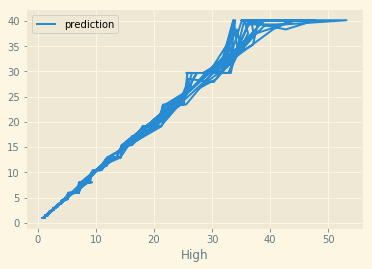

In [30]:
# Convert the Pyspark contructed dataframe to Pandas dataframe to visualize
gbt_predictionsPandas = gbt_predictions.toPandas()

plt.style.use('Solarize_Light2')
gbt_predictionsPandas.plot(x="High" ,y='prediction')

In [31]:
gbt_predictions.describe().show()

+-------+-----------------+------------------+
|summary|             High|        prediction|
+-------+-----------------+------------------+
|  count|             1761|              1761|
|   mean|7.867908806360018| 7.867908806360004|
| stddev| 9.09130871892865| 9.054524340380706|
|    min|         0.766068|0.9642619719356319|
|    max|            53.15| 40.14371878444026|
+-------+-----------------+------------------+



In [34]:
# Gradient-boosted Tree Regression on train and test data (split data)---I2

from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'High', maxIter=15)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)
gbt_predictions.select('prediction', 'High', 'features').show(11)

+------------------+--------+--------------------+
|        prediction|    High|            features|
+------------------+--------+--------------------+
|0.9274965939626173|0.861533|[0.771917,0.86153...|
|0.9274965939626173|0.878762|[0.86104,0.878762...|
|0.9274965939626173|0.921573|[0.887828,0.92157...|
|0.9274965939626173|0.909434|[0.900257,0.90943...|
|0.9274965939626173|0.998996|[0.909894,0.99899...|
|0.9274965939626173|0.956011|[0.913579,0.95601...|
|0.9274965939626173|0.942472|[0.917254,0.94247...|
|0.9274965939626173|0.958333|[0.93027,0.958333...|
|0.9274965939626173|0.941046|[0.941046,0.94104...|
|1.0267042632875298|     1.0|[0.995573,1.0,0.9...|
|1.0516697353811977|    1.04|[1.03,1.04,1.01,1...|
+------------------+--------+--------------------+
only showing top 11 rows



In [35]:
# Root Mean Squared Error (RMSE)
gbt_evaluator_RMSE = RegressionEvaluator(
    labelCol="High", predictionCol="prediction", metricName="rmse")
grmse = gbt_evaluator_RMSE.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) = %g" % grmse)

# Mean Absolute Error (MAE)
gbt_evaluator_MAE = RegressionEvaluator(
    labelCol="High", predictionCol="prediction", metricName="mae")
gmae = gbt_evaluator_MAE.evaluate(gbt_predictions)
print("Mean Absolute Error (MAE) = %g" % gmae)

# R Squarred (R2)
gbt_evaluator_R2 = RegressionEvaluator(
    labelCol="High", predictionCol="prediction", metricName="r2")
gr2 = gbt_evaluator_R2.evaluate(gbt_predictions)
print("R Squarred (R2) = %g" % gr2)

Root Mean Squared Error (RMSE) = 0.980048
Mean Absolute Error (MAE) = 0.375944
R Squarred (R2) = 0.988568


In [38]:
# Gradient-boosted Tree Regression on train and test data (split data)---I3

from pyspark.ml.regression import GBTRegressor
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'High', maxIter=20)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)
gbt_predictions.select('prediction', 'High', 'features').show(11)

# Root Mean Squared Error (RMSE)
gbt_evaluator_RMSE = RegressionEvaluator(
    labelCol="High", predictionCol="prediction", metricName="rmse")
grmse = gbt_evaluator_RMSE.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) = %g" % grmse)

# Mean Absolute Error (MAE)
gbt_evaluator_MAE = RegressionEvaluator(
    labelCol="High", predictionCol="prediction", metricName="mae")
gmae = gbt_evaluator_MAE.evaluate(gbt_predictions)
print("Mean Absolute Error (MAE) = %g" % gmae)

# R Squarred (R2)
gbt_evaluator_R2 = RegressionEvaluator(
    labelCol="High", predictionCol="prediction", metricName="r2")
gr2 = gbt_evaluator_R2.evaluate(gbt_predictions)
print("R Squarred (R2) = %g" % gr2)

+------------------+--------+--------------------+
|        prediction|    High|            features|
+------------------+--------+--------------------+
|0.9267751316592489|0.861533|[0.771917,0.86153...|
|0.9267751316592489|0.878762|[0.86104,0.878762...|
|0.9267751316592489|0.921573|[0.887828,0.92157...|
|0.9267751316592489|0.909434|[0.900257,0.90943...|
|0.9267751316592489|0.998996|[0.909894,0.99899...|
|0.9267751316592489|0.956011|[0.913579,0.95601...|
|0.9267751316592489|0.942472|[0.917254,0.94247...|
|0.9267751316592489|0.958333|[0.93027,0.958333...|
|0.9267751316592489|0.941046|[0.941046,0.94104...|
|1.0259828009841614|     1.0|[0.995573,1.0,0.9...|
|1.0509482730778292|    1.04|[1.03,1.04,1.01,1...|
+------------------+--------+--------------------+
only showing top 11 rows

Root Mean Squared Error (RMSE) = 0.976773
Mean Absolute Error (MAE) = 0.359466
R Squarred (R2) = 0.988644
